# Find Teleconnections (precursor regions) via correlation maps 

In [1]:
import os
from RGCPD import RGCPD
from RGCPD import BivariateMI
from RGCPD import class_BivariateMI, functions_pp, core_pp
from IPython.display import Image
import numpy as np
import pandas as pd

/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: No module named 'networkx'
  warnings.warn(str(e))


In [2]:
path_obs_data = '/data/volume_2/observational/'

target = core_pp.import_ds_lazy(os.path.join(path_obs_data, 'raw', 'chrips_precip_1981-2021.nc'))
hoa_mask = core_pp.import_ds_lazy(os.path.join(path_obs_data, 'chirps_hoa_dry_mask_0.25deg.nc'))
target_timeseries = target.where(hoa_mask).mean(dim=('latitude', 'longitude'))

df_target = target_timeseries.to_dataframe()[['precip']]

# define input by filling list_of_name_path: 
# format list_of_name_path = [('TVname', 'TVpath'), ('prec_name', 'prec_path')]
list_of_name_path = [('', df_target),
                    ('sst', os.path.join(path_obs_data, 'raw', 'era5_sst_1959-2021_1_12_daily_2.0deg.nc'))]

# define analysis:
list_for_MI = [BivariateMI(name='sst', 
                           alpha=.01, FDR_control=True, lags=np.array([1]), 
                           distance_eps=700, min_area_in_degrees2=5)]

sorting longitude


# Time-handling subseasonal mode (OND)

In [3]:
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=28, # <- subseasonal forecasting mode, all data will be aggregated to 10-day means
           start_end_TVdate=('10-01', '12-31'), # <- defining target period 
           start_end_year=(1981, 2021),
           path_outmain='./output_lorentz')

In [4]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)

Loaded pre-processed data of sst



Option for pp_precursors to vary pre-processing of datasets by given a list as an argument:
An example: detrend=[True, {'sm1':False, 'sm2':False}]. This input means that default argument is True, except the variables sm1 and sm2 got a different argument. The precursor names sm1 and sm2 should refer to the names given in list_of_name_path.

### Post-processing Target Variable

Start linear detrending ...
Done
Visual test on 0th observationusing absolute anomalies w.r.t. climatology of smoothed concurrent day accross years
original tfreq of imported response variable is converted to desired 28 (daily) means


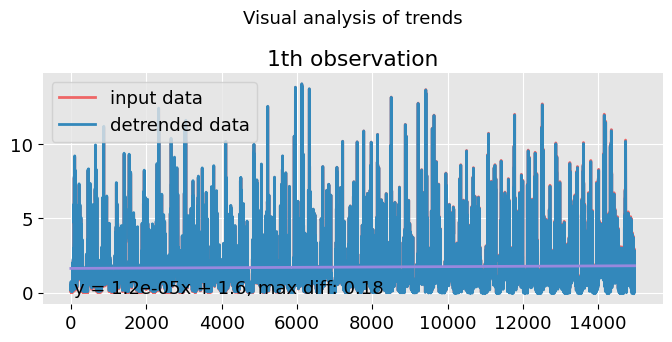

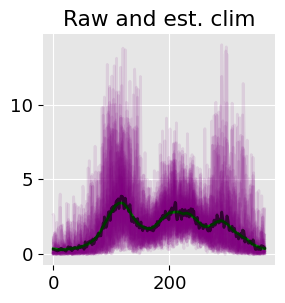

In [5]:
rg.pp_TV(detrend=True, anomaly=True)

In [6]:
rg.df_fullts

,precip
1981-01-16,-0.105955
1981-02-13,0.020717
1981-03-13,1.560154
1981-04-10,1.982569
1981-05-08,-0.089489
...,...
2021-08-28,-0.124701
2021-09-25,0.405102
2021-10-23,-1.109444
2021-11-20,-0.533984


In [7]:
rg.traintest(method='leave_10', gap_prior=1, gap_after=1, seed=2)
# rg._get_testyrs()[0] # see test years

In [8]:
rg.calc_corr_maps() 


sst - calculating correlation maps
Progress traintest set 100%, trainsize=(90dp, 73%)



Plotting sst
Plotting Corr maps sst, split 0, lag 1


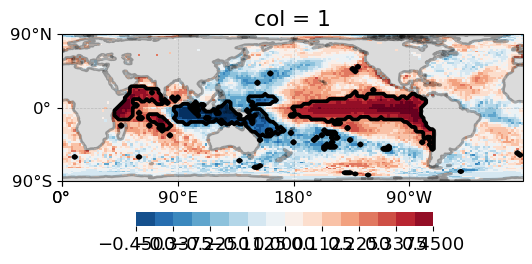

In [9]:
rg.plot_maps_corr()

In [10]:
rg.cluster_list_MI()

Plotting Corr maps sst_labels_init, split 0, lag 1


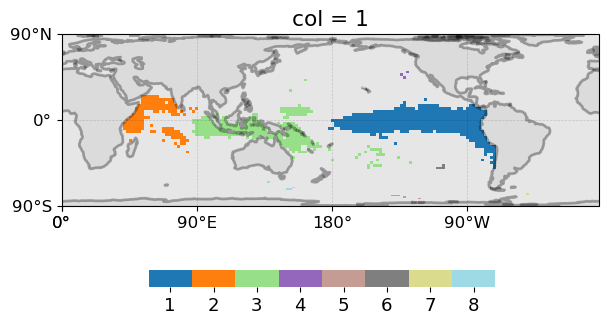

In [11]:
rg.quick_view_labels(mean=True) 

In [12]:
rg.get_ts_prec()


Getting MI timeseries
There are [8, 7, 7, 8] regions in total (list of different splits)


From the correlation (BivariateMI) map, the timeseries are named according the format:
{lag}..{region label}..{precursor name}, where precursor name is defined in list_of_name_path. 

In [13]:
rg.df_data

precip  1..1..sst  1..2..sst  1..3..sst  1..4..sst  1..5..sst  \
0 1981-01-16 -0.105955  -0.770644   0.032892  -0.156652   0.353479   0.190588   
  1981-02-13  0.020717  -0.795492  -0.041271  -0.135320   0.370649   0.195634   
  1981-03-13  1.560154  -0.442178   0.060678  -0.187299   0.236677   0.295502   
  1981-04-10  1.982569  -0.332475  -0.091285  -0.100929  -0.012183   0.261324   
  1981-05-08 -0.089489  -0.154635   0.095927   0.021452   0.076989   0.542373   
...                ...        ...        ...        ...        ...        ...   
3 2021-08-28 -0.124701  -0.332150   0.064190   0.433372   0.156599  -0.068356   
  2021-09-25  0.405102  -0.483970  -0.179740   0.372332  -0.033864  -0.047456   
  2021-10-23 -1.109444  -0.698789  -0.149352   0.535115  -0.335895  -0.116993   
  2021-11-20 -0.533984  -0.842219  -0.071817   0.488540  -0.051904  -0.156833   
  2021-12-18  0.017693  -1.001179   0.097456   0.345841  -0.050526  -0.151956   

              1..6..sst  1..7..sst  1..8..sst  TrainIsTrue  RV_mask  
0 1981-01-16   0.293472   0.135946   0.030519            0    False  
  1981-02-13   0.460081   0.003131   0.017934            0    False  
  1981-03-13   0.962230   0.068266   0.060200            0    False  
  1981-04-10   0.124878   0.161600   0.052381            0    False  
  1981-05-08   0.208433   0.199510   0.062236            0    False  
...                 ...        ...        ...          ...      ...  
3 2021-08-28   0.148477   0.237912   0.249465            0    False  
  2021-09-25   0.118922   0.240769   0.236565            0    False  
  2021-10-23   0.240895   0.226840   0.258281            0     True  
  2021-11-20   0.652426   0.114592   0.197296            0     True  
  2021-12-18   0.470615  -0.073469  -0.089215            0     True  

[2132 rows x 11 columns]

## Train-test cross-validation and Response Variable mask handling

- The different train-test folds are organized in the first level index.
- Each fold contains precursor timeseries that were extracted from only training data.
- The Training data is specified by the TrainIsTrue mask.
- The Response Variable mask defined the dates to predict 
- The RV_mask the anker for lag shifting the precursors.

The last two columns should be always present. 
- The RV_mask is defined by the start_end_TVdate.
- The TrainIsTrue is defined by the method for cross-validation.


In [14]:
# Example lag shifting
from RGCPD.forecasting import func_models as fc_utils
fc_utils.apply_shift_lag(rg.df_splits.loc[0].copy(), lag_i=1)

,TrainIsTrue,x_fit,y_fit,x_pred,y_pred
1981-01-16,0,False,False,False,False
1981-02-13,0,False,False,False,False
1981-03-13,0,False,False,False,False
1981-04-10,0,False,False,False,False
1981-05-08,0,False,False,False,False
...,...,...,...,...,...
2021-08-28,1,False,False,False,False
2021-09-25,1,True,False,True,False
2021-10-23,1,True,True,True,True
2021-11-20,1,True,True,True,True


# Forecasting pipeline 1

In [15]:
from RGCPD.forecasting import func_models as fc_utils
from RGCPD.forecasting.stat_models_cont import ScikitModel
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV


# choose type prediciton (continuous or probabilistic) by making comment #
prediction = 'continuous'   
prediction = 'events' ; q = .33 # quantile threshold for event definition

if prediction == 'continuous':
    model = ScikitModel(Ridge, verbosity=0)
    # You can also tune parameters by passing a list of values. Then GridSearchCV from sklearn will 
    # find the set of parameters that give the best mean score on all kfold test sets. 
    # below we pass a list of alpha's to tune the regularization.
    alphas = list(np.concatenate([[1E-20],np.logspace(-5,0, 6), np.logspace(.01, 2.5, num=25)]))                       
    kwrgs_model = {'scoringCV':'neg_mean_absolute_error',
                   'kfold':5,
                   'alpha':alphas} # large a, strong regul.
elif prediction == 'events':
    model = ScikitModel(LogisticRegressionCV, verbosity=0)
    kwrgs_model = {'kfold':5,
                   'scoring':'neg_brier_score'}

    

target_ts = rg.TV.RV_ts ; 
target_ts = (target_ts - target_ts.mean()) / target_ts.std()
if prediction == 'events':
    if q >= 0.5:
        target_ts = (target_ts > target_ts.quantile(q)).astype(int)
    elif q < .5:
        target_ts = (target_ts < target_ts.quantile(q)).astype(int)
    BSS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).BSS
    score_func_list = [BSS, fc_utils.metrics.roc_auc_score]
    
elif prediction == 'continuous':
    RMSE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).RMSE
    MAE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).MAE
    score_func_list = [RMSE_SS, fc_utils.corrcoef, MAE_SS]
        
    
out = rg.fit_df_data_ridge(target=target_ts,
                           keys=None,
                           fcmodel=model,
                           kwrgs_model=kwrgs_model,
                           transformer=False,
                           tau_min=1, tau_max=3)
predict, weights, model_lags = out

df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
                                                                 rg.df_data.iloc[:,-2:],
                                                                 score_func_list,
                                                                 n_boot = 100,
                                                                 score_per_test=False,
                                                                 blocksize=1,
                                                                 rng_seed=1)
lag = 1
if prediction == 'events':
    print(model.scikitmodel.__name__, '\n', f'Test score at lag {lag}\n',
          'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[lag].loc['BSS']),
          'AUC {:.2f}'.format(df_test_m.loc[0].loc[lag].loc['roc_auc_score']),
          '\nTrain score\n',
          'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['BSS']),
          'AUC {:.2f}'.format(df_train_m.mean(0).loc[lag]['roc_auc_score']))
elif prediction == 'continuous':
    print(model.scikitmodel.__name__, '\n', 'Test score\n',
              'RMSE {:.2f}\n'.format(df_test_m.loc[0][lag]['RMSE']),
              'MAE {:.2f}\n'.format(df_test_m.loc[0][lag]['MAE']),
              'corrcoef {:.2f}'.format(df_test_m.loc[0][lag]['corrcoef']),
              '\nTrain score\n',
              'RMSE {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['RMSE']),
              'MAE {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['MAE']),
              'corrcoef {:.2f}'.format(df_train_m.mean(0).loc[lag]['corrcoef']))

LogisticRegressionCV 
 Test score at lag 1
 BSS 0.07
 AUC 0.64 
Train score
 BSS 0.16
 AUC 0.74


<AxesSubplot:>

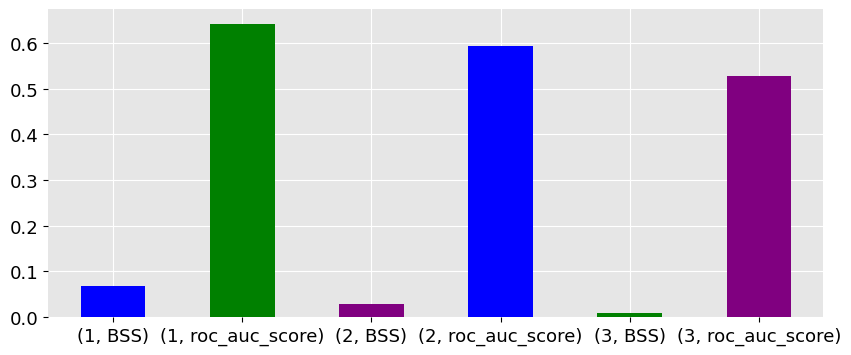

In [16]:
df_test_m.loc[0].plot.bar(rot=0, color=['blue', 'green', 'purple'], figsize=(10,4))

/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


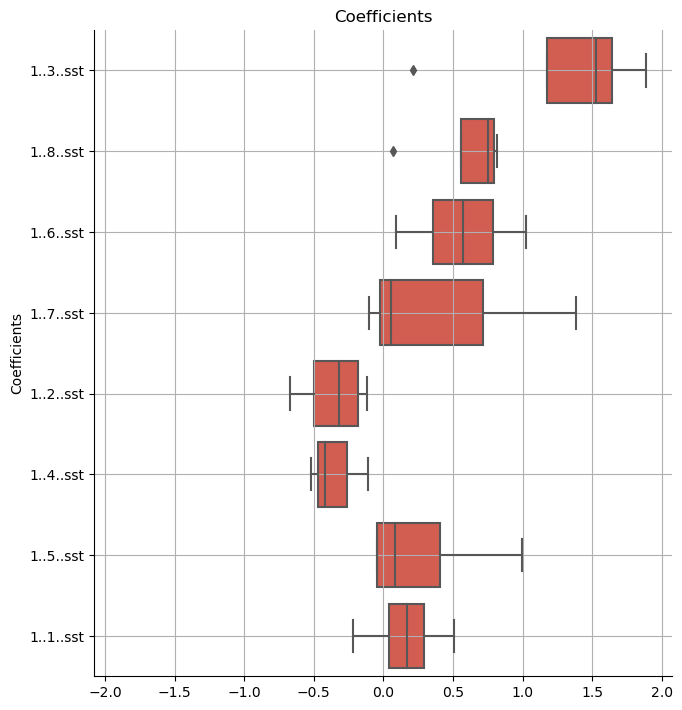

In [17]:
from RGCPD.forecasting.stat_models import plot_importances
coeff, fig = plot_importances(models_splits_lags=model_lags, lag=1)
fig

## Causal Discovery using Tigramite

In [18]:
rg.PCMCI_df_data(tigr_function_call='run_pcmci',
                 kwrgs_tigr={'tau_min': 0,
                             'tau_max': 1,
                             'pc_alpha': 0.05,
                             'max_conds_dim': 2,
                             'max_combinations': 2,
                             'max_conds_py': 2,
                             'max_conds_px': 2})

Progress causal inference - traintest set 100%

In [19]:
rg.PCMCI_get_links(var=rg.TV.name, alpha_level=.05, FDR_cv=False)
rg.df_links

0      1
0 precip     False  False
  1..1..sst  False  False
  1..2..sst   True  False
  1..3..sst  False   True
  1..4..sst  False  False
  1..5..sst  False  False
  1..6..sst  False  False
  1..7..sst  False  False
  1..8..sst  False  False
1 precip     False  False
  1..1..sst  False  False
  1..2..sst   True  False
  1..3..sst  False   True
  1..5..sst  False  False
  1..6..sst  False  False
  1..7..sst  False  False
  1..8..sst  False  False
2 precip     False  False
  1..1..sst  False  False
  1..2..sst   True  False
  1..3..sst   True   True
  1..4..sst  False  False
  1..5..sst  False  False
  1..6..sst  False  False
  1..8..sst  False  False
3 precip     False  False
  1..1..sst  False  False
  1..2..sst   True  False
  1..3..sst   True   True
  1..4..sst  False  False
  1..5..sst  False  False
  1..6..sst  False  False
  1..7..sst  False  False
  1..8..sst  False  False


Plotting all fields significant at alpha_level_tig, while conditioning on parents that were found in the PC step
Plotting Corr maps sst_labels, split 0, lag sst_labels
Plotting Corr maps sst_labels, split 0, lag sst_labels_tigr


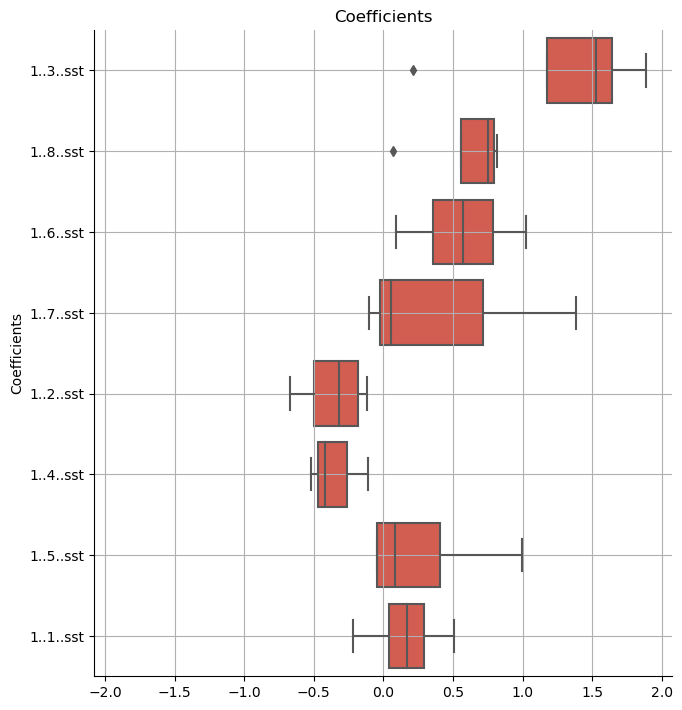

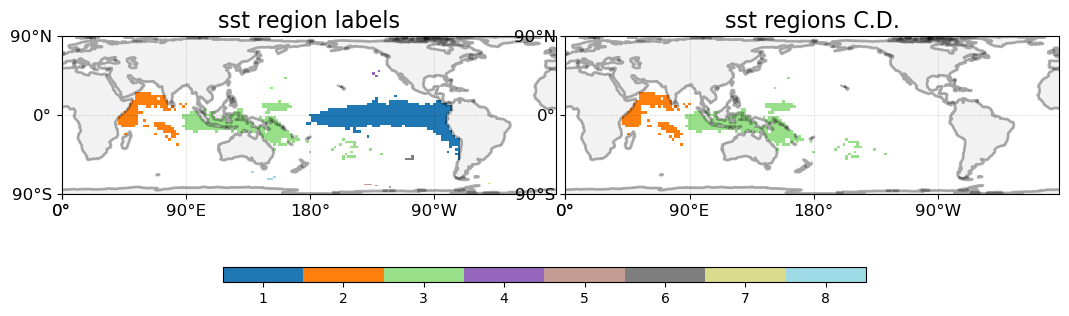

Plotting Corr maps sst_labels, split 0, lag sst_labels
Plotting Corr maps sst_labels, split 0, lag sst_labels_tigr


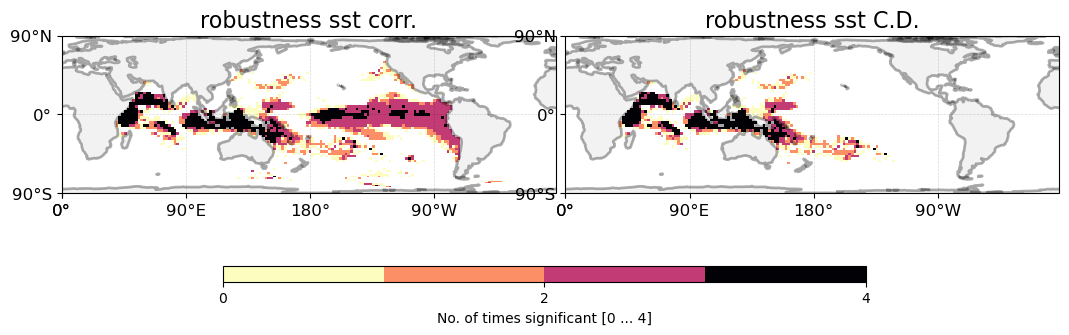


Plotting all fields significant at alpha_level_tig, while conditioning on parents that were found in the PC step
Plotting Corr maps sst_corr_and_tigr, split 0, lag sst_corr
Plotting Corr maps sst_corr_and_tigr, split 0, lag sst_corr_tigr


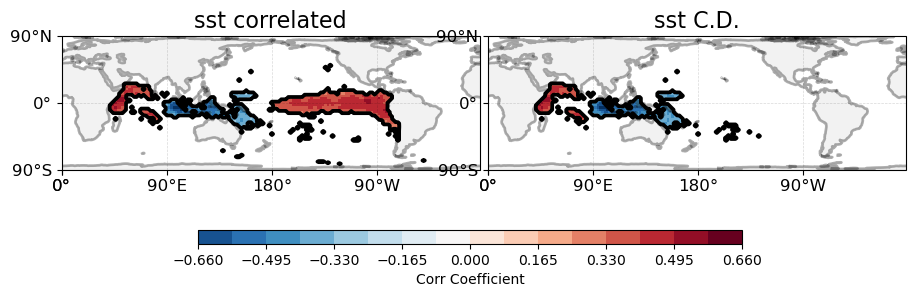

In [20]:
# on the left you see all the extraction precursor regions, on the right you see the regions which were found Conditionally Dependent (~Causal)
rg.plot_maps_sum()